Example of time and angle interpolation. 

The first cell sets up the interpolators in standard fashion as the other notebook examples. One notable difference is that a single wavelength is randomly chosen (between g and K, or 476 and 2190 nm) for the light curves.

The second cell chooses an offset variable which is added to/subtracted from the angle considered for the models; so, for example, 45 +- 12 would yield light curve examples at 33, 45, and 57 degrees, with the 33 and 57 degree light curves resulting from interpolation. 

The interpolation in angle and time is done for each of the two angles above and below the base angle (45 degrees in the above example case).

The final cell plots the results of the time and angle interpolation. Time interpolation is verified by showing that none of the times in the interpolated light curves are the same as in the models. The solid black line represents the interpolator prediction at the angle for which the models were trained. The circles (stars) represent the light curves at the angle obtained when the offset was added to (subtracted from) the base angle.


In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "12"
import glob
import numpy as np
import save_sklearn_gp as ssg
from natsort import natsorted
from scipy.linalg import cholesky, cho_solve

angles = ['00', '30', '45', '60', '75', '90']
angle = np.random.choice(angles)
while angle == '00' or angle == '90':
    angle = np.random.choice(angles) # forbids extrapolation by ensuring chosen angle is well within interpolation bounds

files = glob.glob('surrogate_data/2021_Wollaeger_TorusPeanut/theta'+angle+'deg/*')
files = natsorted(files) # sorting is necessary! otherwise time will be out of order

x_train = np.loadtxt(files[-1]+'/model_X.dat') # all files do NOT have the same X training data, but loading from the last one ensures that the previous interpolators will include that event
idx = np.random.randint(x_train.shape[0]) # randomly choose one of the events in the training set
while x_train[idx][-1] > 2200: # removes the S-band from consideration
    idx = random.choice(range(x_train.shape[0])) # chooses a random wavelength at which to generate light curves
inputs = x_train[None, idx]

for file in files:
	fname = file+'/model'
	model = ssg.load_gp(fname) # loading Gaussian Process from hyperparameters saved in .json format
    
	pred, err = ssg.predict(model, inputs)
    
	x_train = np.loadtxt(file+'/model_X.dat') # size of training set changes at later times (not all sims go out to same time)
	idx = np.argmin([np.sum(np.abs(x_train[idx, :]-inputs[0, :])) for idx in range(x_train.shape[0])]) # finds index for inputs
	sim = np.loadtxt(file+'/model_y.dat')[idx]
	sim *= model._y_train_std
	sim += model._y_train_mean
    
	try:
		lc = np.append(lc, pred)
		sim_lc = np.append(sim_lc, sim)
	except NameError:
		lc = pred # if first time point, initializes the light curve array
		sim_lc = sim


In [2]:
import sys, os
sys.path.append('python/')
from kn_interp_angle import kn_interp_angle

offset = np.random.uniform(0, 15)
wavs = np.array([476., 621., 754., 900., 1020., 1220., 1630., 2190., 4493.])
bands = 'grizyJHK'
inputs = inputs.flatten()

os.environ["INTERP_LOC"] = './'

model = kn_interp_angle()

params = {"mej_dyn":inputs[0], "vej_dyn":inputs[1], "mej_wind":inputs[2], "vej_wind":inputs[3], "theta":int(angle)+offset}

t = np.logspace(np.log10(0.2), np.log10(37), 20)
b = bands[np.argmin(np.abs(wavs-inputs[-1]))]

model.set_params(params, (0, 0))

pred_above, err = model.evaluate(t, b)

model = kn_interp_angle()

params = {"mej_dyn":inputs[0], "vej_dyn":inputs[1], "mej_wind":inputs[2], "vej_wind":inputs[3], "theta":int(angle)-offset}

model.set_params(params, (0, 0))

pred_below, err = model.evaluate(t, b)

i band:
  evaluating time step 1 of 28
  evaluating time step 5 of 28
  evaluating time step 10 of 28
  evaluating time step 15 of 28
  evaluating time step 20 of 28
  evaluating time step 25 of 28
i band:
  evaluating time step 1 of 28
  evaluating time step 5 of 28
  evaluating time step 10 of 28
  evaluating time step 15 of 28
  evaluating time step 20 of 28
  evaluating time step 25 of 28


False


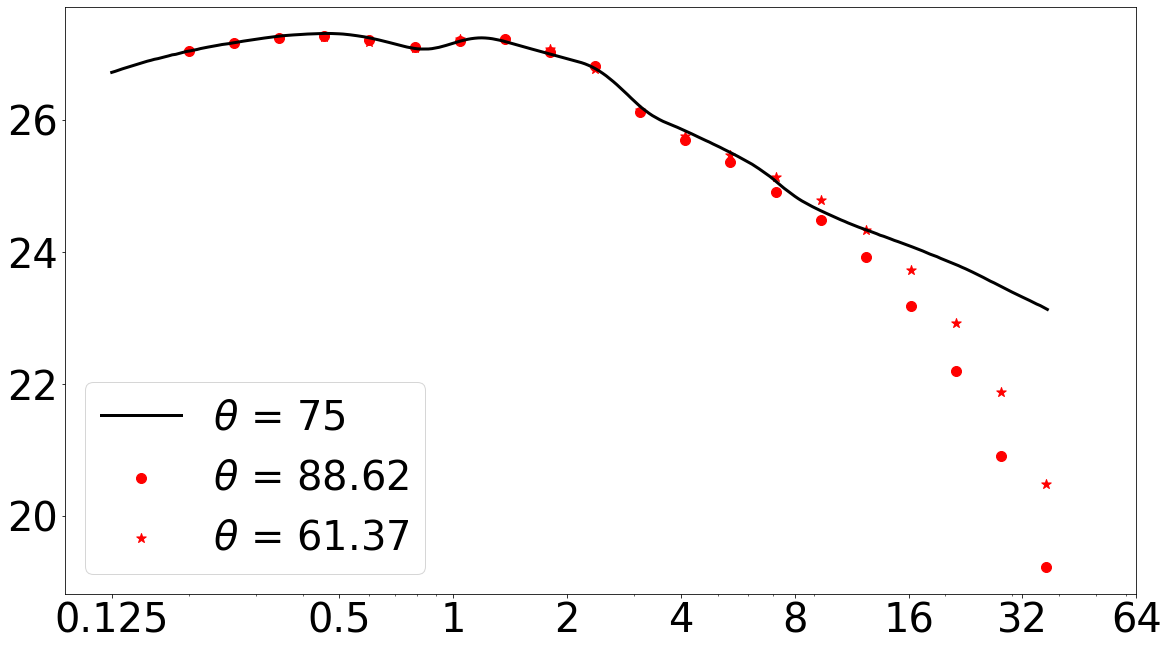

In [3]:
#import matplotlib
#matplotlib.use('Agg')
from matplotlib import ticker
import matplotlib.pyplot as plt
#%matplotlib inline

times = np.logspace(np.log10(0.125), np.log10(37.239195485411194), 264)

print(np.any(np.isin(t, times))) # verify that all user-requested times are different from interpolator time points

plt.rc('font', size = 40)
plt.rc('lines', lw=4)
plt.figure(figsize=(19.2, 10.8))
plt.plot(times, sim_lc, lw=3, c='k', label=r'$\theta$ = %s' % angle)
plt.scatter(t, pred_above, s=100, c='r', label=r'$\theta$ = %s' % str(float(angle)+offset)[:5])
plt.scatter(t, pred_below, s=100, c='r', marker='*', label=r'$\theta$ = %s' % str(float(angle)-offset)[:5])
plt.xscale("log")
plt.gca().set_xticks([0.125, 0.5, 1, 2, 4, 8, 16, 32, 64])
plt.gca().get_xaxis().set_major_formatter(ticker.FormatStrFormatter('%g'))
plt.legend()
plt.show()